<a href="https://colab.research.google.com/github/teacherSsamko/DL-study/blob/main/w2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [2주차] 심화과제: Multi-head Attention으로 감정 분석 모델 구현하기

In [2]:
!pip install datasets sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []
  for row in batch:
    labels.append(row['label'])
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  labels = torch.LongTensor(labels)

  return texts, labels


train_loader = DataLoader(
    ds['train'], batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=32, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## [MY CODE] MHA


In [1]:
from torch import nn
from math import sqrt


class MHA(nn.Module):
  def __init__(self, input_dim, n_heads, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.num_heads = n_heads
    self.d_model = d_model
    self.d_k = d_model // n_heads

    assert d_model % n_heads == 0

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    batch_size = x.size(0)
    seq_len = x.size(1)

    q, k, v = self.wq(x), self.wk(x), self.wv(x)

    # print(f"Original q shape: {q.shape}")

    # q, k, v를 head별로 나누기
    q = q.view(batch_size, seq_len, self.num_heads, self.d_k)
    k = k.view(batch_size, seq_len, self.num_heads, self.d_k)
    v = v.view(batch_size, seq_len, self.num_heads, self.d_k)

    # print(f"After view q shape: {q.shape}")


    # S H D 를 H S D로
    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)


    # Scaled dot-product attention
    scores = torch.matmul(q, k.transpose(-2, -1)) / sqrt(self.d_k)

    # print(f"Scores shape: {scores.shape}")
    # print(f"Mask shape: {mask.shape}")


    if mask is not None:
      mask = mask.unsqueeze(1)
      mask = mask.unsqueeze(1)
      # print(f"Mask shape after unsqueeze: {mask.shape}")
      mask = mask.expand(-1, self.num_heads, seq_len, -1)
      # print(f"Mask shape after expand: {mask.shape}")
      scores = scores.masked_fill(mask, -1e9)

    score = self.softmax(scores)
    result = torch.matmul(score, v)

    result = result.permute(0, 2, 1, 3).contiguous()
    result = result.view(batch_size, seq_len, self.d_model)

    result = self.dense(result)

    return result

## [MY CODE] Transformer Layer 수정

In [4]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff
    self.num_heads = 4

    self.mha = MHA(input_dim, self.num_heads, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.dropout = nn.Dropout(0.1)
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)

  def forward(self, x, mask):
    attn_out = self.mha(self.norm1(x), mask)
    # print(attn_out.shape)
    # print(x.shape)
    x = x + self.dropout(attn_out)

    ffn_out = self.ffn(self.norm2(x))
    x = x + self.dropout(ffn_out)

    return x

In [5]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [6]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, 1)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    # print(f"Initial mask shape: {mask.shape}")

    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]


    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, 0]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 2, 32)

In [7]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  model.eval()
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [9]:
n_epochs = 50
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    train_acc_list.append(train_acc)
    test_acc = accuracy(model, test_loader)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 389.77253529429436
=========> Train acc: 0.857 | Test acc: 0.832
Epoch   1 | Train Loss: 250.27454987168312
=========> Train acc: 0.893 | Test acc: 0.850
Epoch   2 | Train Loss: 202.42090655118227
=========> Train acc: 0.921 | Test acc: 0.858
Epoch   3 | Train Loss: 168.76304069161415
=========> Train acc: 0.940 | Test acc: 0.854
Epoch   4 | Train Loss: 139.62274022214115
=========> Train acc: 0.955 | Test acc: 0.850
Epoch   5 | Train Loss: 110.71782618807629
=========> Train acc: 0.953 | Test acc: 0.828
Epoch   6 | Train Loss: 86.60807303059846
=========> Train acc: 0.971 | Test acc: 0.838
Epoch   7 | Train Loss: 65.03657980030403
=========> Train acc: 0.986 | Test acc: 0.829
Epoch   8 | Train Loss: 44.916991672245786
=========> Train acc: 0.993 | Test acc: 0.832
Epoch   9 | Train Loss: 33.726020033238456
=========> Train acc: 0.993 | Test acc: 0.829
Epoch  10 | Train Loss: 24.801646561478265
=========> Train acc: 0.992 | Test acc: 0.819
Epoch  11 | Train Loss:

KeyboardInterrupt: 

## [LOG] 과적합 발생으로 조기종료

In [10]:
def plot_acc(accs1, accs2, label1='', label2='', title=None):
  x = np.arange(len(accs1))

  plt.plot(x, accs1, label=label1)
  plt.plot(x, accs2, label=label2)
  plt.legend()
  if title:
    plt.title(title)
  plt.show()

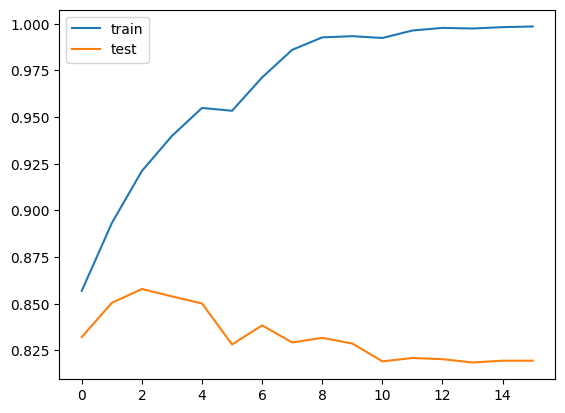

In [11]:
plot_acc(train_acc_list, test_acc_list, 'train', 'test')

## [MY CODE] 5layers 4heads Transformer

In [12]:
model = TextClassifier(len(tokenizer), 32, 5, 32)
model = model.to('cuda')
optimizer = Adam(model.parameters(), lr=lr)

In [13]:
n_epochs = 50
train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda').float()

    preds = model(inputs)[..., 0]
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    train_acc_list.append(train_acc)
    test_acc = accuracy(model, test_loader)
    test_acc_list.append(test_acc)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

Epoch   0 | Train Loss: 426.5364040732384
=========> Train acc: 0.858 | Test acc: 0.835
Epoch   1 | Train Loss: 252.85053877532482
=========> Train acc: 0.901 | Test acc: 0.851
Epoch   2 | Train Loss: 202.2662258259952
=========> Train acc: 0.924 | Test acc: 0.855
Epoch   3 | Train Loss: 167.2090637125075
=========> Train acc: 0.934 | Test acc: 0.852
Epoch   4 | Train Loss: 134.9328119661659
=========> Train acc: 0.964 | Test acc: 0.849
Epoch   5 | Train Loss: 100.78629045374691
=========> Train acc: 0.959 | Test acc: 0.828


KeyboardInterrupt: 

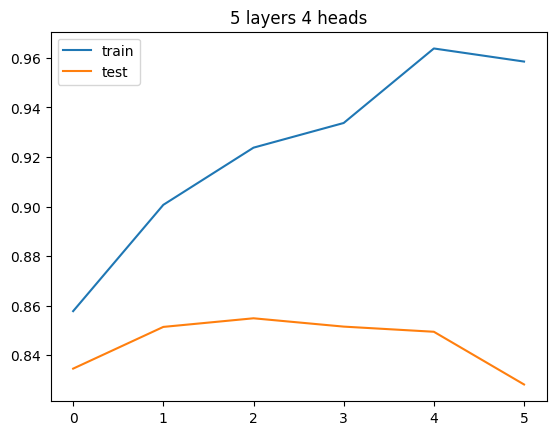

In [14]:
plot_acc(train_acc_list, test_acc_list, 'train', 'test', '5 layers 4 heads')

## [LOG] 과적합 발생

## [FEEDBACK] 이렇게 빨리 과적합이 발생하는건 잘못된걸까요?